In [1]:
# Imports
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import norm, moment
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from IPython.display import display

In [2]:
from mlfinlab.bet_sizing import (bet_size_probability, bet_size_dynamic, bet_size_budget, bet_size_reserve,
                                 confirm_and_cast_to_df, get_concurrent_sides, cdf_mixture, single_bet_size_mixed,
                                 M2N, centered_moment, raw_moment, most_likely_parameters)
from mlfinlab.bet_sizing.ch10_snippets import (avg_active_signals, bet_size_power)

----
#### EXERCISE 10.1
Using the formulation in Section 10.3, plot the bet size ($m$) as a function of the maximum predicted probability ($\tilde{p}$) when $||X|| = 2, 3, ..., 10$.

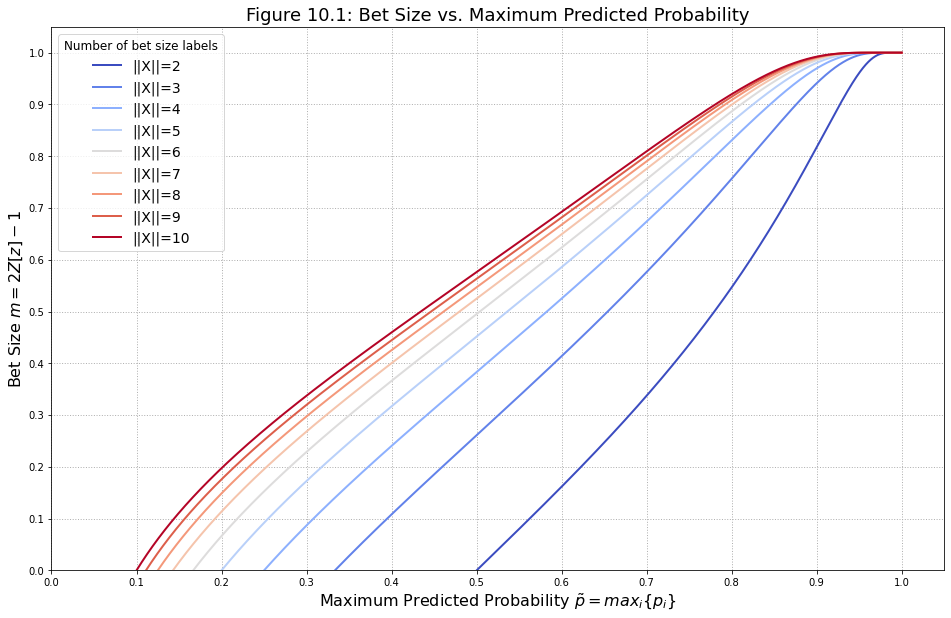

In [3]:
num_classes_list = [i for i in range(2, 11, 1)]  # Array of number of classes, 2 to 10
sample_size = 10_000  # Number of points to plot
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

# Setup the t1 Series, also used for exercise 10.2

# Create the array of dates
start_date = dt.datetime(2000, 1, 1)  # Starting at 01-JAN-2000
date_step = dt.timedelta(days=1)
dates = np.array([start_date + i*date_step for i in range(sample_size)])
# Create the array of shifted dates to be the end date of the bet
shift_list = np.random.uniform(1., 25., sample_size)
shift_dt = np.array([dt.timedelta(days=d) for d in shift_list])
# Combine into a pandas.Series object
dates_shifted = dates + shift_dt
t1 = pd.Series(data=dates_shifted, index=dates)

# Start plotting loop
fig_10_1, ax_10_1 = plt.subplots(figsize=(16, 10))

for num_classes in num_classes_list:
    # Create the array of random probabilities
    min_prob, max_prob = 1 / num_classes, 1  # Possible range for maximum predicted probability, [1/||X||, 1]
    P = np.linspace(min_prob, max_prob, sample_size, endpoint=False)  # Range of maximum predicted probabilities to plot
    # Combine probabilities with 't1' Series into a DataFrame for the bet size function.
    events_n_classes = pd.DataFrame({'t1': t1, 'prob': P})
    events_n_classes['bet_size_prob'] = bet_size_probability(events=events_n_classes, prob=events_n_classes['prob'], num_classes=num_classes)
    ax_10_1.plot(events_n_classes['prob'], events_n_classes['bet_size_prob'], label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

ax_10_1.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=16)
ax_10_1.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=16)
ax_10_1.set_title("Figure 10.1: Bet Size vs. Maximum Predicted Probability", fontsize=18)
ax_10_1.set_xticks([0.1*i for i in range(11)])
ax_10_1.set_yticks([0.1*i for i in range(11)])
ax_10_1.legend(loc="upper left", fontsize=14, title="Number of bet size labels", title_fontsize=12)
ax_10_1.set_ylim((0,1.05))
ax_10_1.set_xlim((0, 1.05))
ax_10_1.grid(linewidth=1, linestyle=':')

plt.show()

In [4]:
sample_size

10000

In [5]:
t1.head(20)

2000-01-01   2000-01-18 09:52:55.127172
2000-01-02   2000-01-14 05:50:47.037544
2000-01-03   2000-01-05 11:27:59.715645
2000-01-04   2000-01-15 21:25:39.471161
2000-01-05   2000-01-20 02:28:38.652251
2000-01-06   2000-01-25 05:23:41.738727
2000-01-07   2000-01-11 07:20:15.605093
2000-01-08   2000-01-25 21:06:25.611093
2000-01-09   2000-01-26 03:18:31.241395
2000-01-10   2000-01-25 23:31:15.504108
2000-01-11   2000-01-21 08:08:28.664375
2000-01-12   2000-02-02 01:16:02.370712
2000-01-13   2000-01-27 16:29:44.213438
2000-01-14   2000-01-28 00:12:14.051083
2000-01-15   2000-02-03 03:42:00.360750
2000-01-16   2000-01-24 12:11:10.282535
2000-01-17   2000-02-01 01:30:49.290757
2000-01-18   2000-01-24 03:16:22.165073
2000-01-19   2000-02-12 12:21:33.204357
2000-01-20   2000-01-22 19:26:07.149424
dtype: datetime64[ns]

In [6]:
num_classes_list

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [7]:
P

array([0.1    , 0.10009, 0.10018, ..., 0.99973, 0.99982, 0.99991])

In [8]:
len(P)

10000

In [9]:
events_n_classes

,t1,prob,bet_size_prob
2000-01-01,2000-01-18 09:52:55.127172,0.10000,0.000000
2000-01-02,2000-01-14 05:50:47.037544,0.10009,0.000239
2000-01-03,2000-01-05 11:27:59.715645,0.10018,0.000478
2000-01-04,2000-01-15 21:25:39.471161,0.10027,0.000717
2000-01-05,2000-01-20 02:28:38.652251,0.10036,0.000956
...,...,...,...
2027-05-14,2027-05-22 23:00:13.351701,0.99955,1.000000
2027-05-15,2027-05-30 21:53:27.373770,0.99964,1.000000
2027-05-16,2027-06-02 07:05:51.550529,0.99973,1.000000
2027-05-17,2027-06-01 03:26:35.212585,0.99982,1.000000


----
#### EXERCISE 10.2
Draw 10,000 random numbers from a uniform distribution with bounds U[.5, 1.]. (Author's note: These exercises are intended to simulate dynamic bet sizing of a long-only strategy.)

__(a)__ Compute bet sizes _m_ for $||X||=2$.

__(b)__ Assign 10,000 consecutive calendar days to the bet sizes.

__(c)__ Draw 10,000 random numbers from a uniform distribution with bounds U[1, 25].

__(d)__ Form a `pandas.Series` indexed by the dates in 2.b, and with values equal to the index shifted forward the number of days in 2.c. This is a `t1` object similar to the ones we used in Chapter 3.

__(e)__ Compute the resulting average active bets, following Section 10.4.
 

In [10]:
# Draw random numbers from a uniform distribution (all bets are long)
np.random.seed(0)
sample_size = 10_000
P_t = np.random.uniform(.5, 1., sample_size)  # Array of random from uniform dist

# Create events DataFrame from P_t and t1 (previous exercise)
events_2_classes = pd.DataFrame({'t1': t1, 'prob': P_t})

# 10.2(a) Compute bet sizes for ||X||=2
events_2_classes['bet_size_prob'] = bet_size_probability(events=events_2_classes, prob=events_2_classes['prob'], num_classes=2)

# 10.2(b) Assign 10,000 consecutive calendar days
# See previous code cell

# 10.2(c) Draw 10,000 random numbers from a uniform distribution
# See previous code cell

# 10.2(d) Create a pandas.Series object
# See previous cell

# Since this is a long-only strategy, all bet sides are '1'
events_2_classes['side'] = 1

# 10.2(e) Compute the average active bets (sizes)
# Calculate the concurrent long and short bets
avg_active_bet_sizes = avg_active_signals(events_2_classes.rename(columns={'bet_size_prob': 'signal'}), num_threads=cpu_count())
events_2_classes['avg_active_bet_size'] = avg_active_bet_sizes

print("The first 10 rows of the resulting DataFrame from Exercise 10.2:")
display(events_2_classes.head(10))
print("Summary statistics on the bet size columns:")
display(events_2_classes[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())

2022-01-30 14:51:44.599119 100.0% mp_avg_active_signals done after 0.68 minutes. Remaining 0.0 minutes.


The first 10 rows of the resulting DataFrame from Exercise 10.2:


,t1,prob,bet_size_prob,side,avg_active_bet_size
2000-01-01,2000-01-18 09:52:55.127172,0.774407,0.488510,1,0.488510
2000-01-02,2000-01-14 05:50:47.037544,0.857595,0.693816,1,0.591163
2000-01-03,2000-01-05 11:27:59.715645,0.801382,0.550002,1,0.577443
2000-01-04,2000-01-15 21:25:39.471161,0.772442,0.484193,1,0.554130
2000-01-05,2000-01-20 02:28:38.652251,0.711827,0.360002,1,0.515304
2000-01-06,2000-01-25 05:23:41.738727,0.822947,0.602473,1,0.525799
2000-01-07,2000-01-11 07:20:15.605093,0.718794,0.373496,1,0.500415
2000-01-08,2000-01-25 21:06:25.611093,0.945887,0.951258,1,0.564821
2000-01-09,2000-01-26 03:18:31.241395,0.981831,0.999691,1,0.619180
2000-01-10,2000-01-25 23:31:15.504108,0.691721,0.321986,1,0.586158


Summary statistics on the bet size columns:


,prob,bet_size_prob,avg_active_bet_size
count,10000.000000,10000.000000,10000.000000
mean,0.748229,0.473318,0.471183
std,0.144803,0.312169,0.084280
min,0.500036,0.000058,0.140137
25%,0.622655,0.199764,0.415112
50%,0.746751,0.429563,0.470186
75%,0.874146,0.740689,0.526123
max,0.999989,1.000000,0.803430


In [11]:
# 10.3(a) Max number of concurrent long bets
# 10.3(b) Max number of concurrent short bets
events_10_3 = events_2_classes.copy()
concurrent_bets = get_concurrent_sides(events_10_3['t1'], events_10_3['side'])
active_long_max, active_short_max = concurrent_bets['active_long'].max(), concurrent_bets['active_short'].max()
print(f"  10.3(a) Maximum number of concurrent long bets: {active_long_max}")
print(f"  10.3(b) Maximum number of concurrent short bets: {active_short_max}")


# 10.3(c) Bet size as difference between fractions of concurrent long and short bets
# Handle possible division by zero
df_budget = bet_size_budget(events_10_3['t1'], events_10_3['side'])
df_budget = df_budget.rename(columns={'bet_size': 'bet_size_budget'})

display(df_budget.head(10))

  10.3(a) Maximum number of concurrent long bets: 21
  10.3(b) Maximum number of concurrent short bets: 0


,t1,side,active_long,active_short,bet_size_budget
2000-01-01,2000-01-18 09:52:55.127172,1,1,0,0.047619
2000-01-02,2000-01-14 05:50:47.037544,1,2,0,0.095238
2000-01-03,2000-01-05 11:27:59.715645,1,3,0,0.142857
2000-01-04,2000-01-15 21:25:39.471161,1,4,0,0.190476
2000-01-05,2000-01-20 02:28:38.652251,1,5,0,0.238095
2000-01-06,2000-01-25 05:23:41.738727,1,5,0,0.238095
2000-01-07,2000-01-11 07:20:15.605093,1,6,0,0.285714
2000-01-08,2000-01-25 21:06:25.611093,1,7,0,0.333333
2000-01-09,2000-01-26 03:18:31.241395,1,8,0,0.380952
2000-01-10,2000-01-25 23:31:15.504108,1,9,0,0.428571


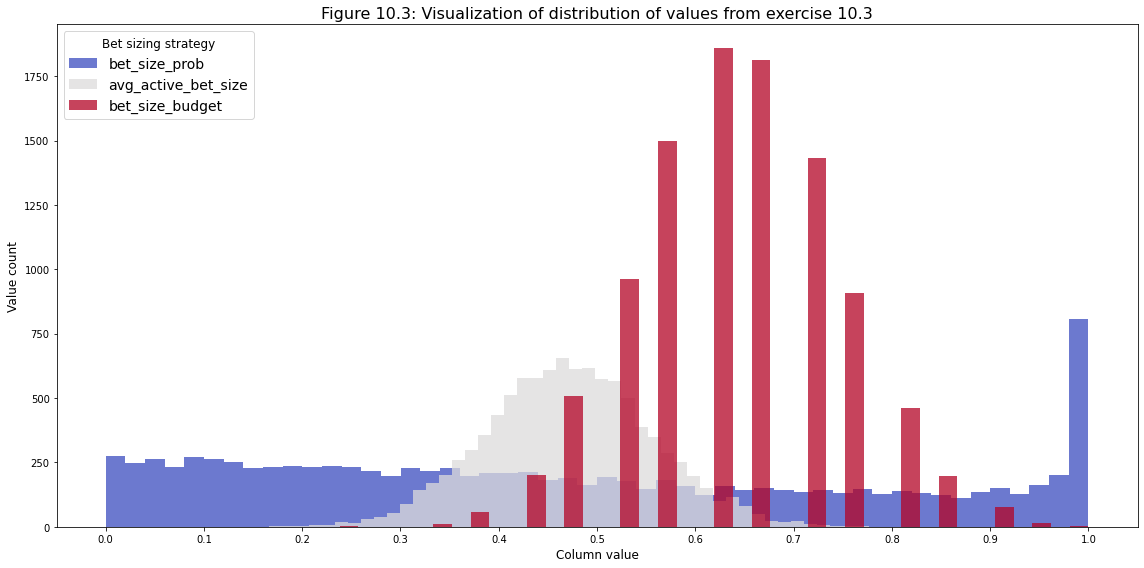

In [12]:
# Plot the frequency of different bet sizes
# Start by gathering different bet sizes into one DataFrame
betsizes_10_3 = events_2_classes[['bet_size_prob', 'avg_active_bet_size']].copy()
betsizes_10_3['bet_size_budget'] = df_budget['bet_size_budget'].copy()

# Start plotting code
fig_10_3, ax_10_3 = plt.subplots(figsize=(16, 8))
colors = iter(cm.coolwarm(np.linspace(0,1,3)))
n_bins = 50
for i, col in enumerate(['bet_size_prob', 'avg_active_bet_size', 'bet_size_budget']):
    ax_10_3.hist(betsizes_10_3[col], bins=n_bins, alpha=0.75, color=colors.__next__(), label=col)
ax_10_3.set_xticks([i/10 for i in range(11)])
ax_10_3.set_xlabel("Column value", fontsize=12)
ax_10_3.set_ylabel("Value count", fontsize=12)
ax_10_3.set_title("Figure 10.3: Visualization of distribution of values from exercise 10.3", fontsize=16)
ax_10_3.legend(loc="upper left", fontsize=14, title="Bet sizing strategy", title_fontsize=12)
fig_10_3.tight_layout()
plt.show()

----
#### EXERCISE 10.4
Using the `t1` object from exercise 2.d:

__(a)__ Compute the series $c_t = c_{t,l} - c_{t,s}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

__(b)__ Fit a mixture of two Gaussians on {$c_t$}. You may want to use the method described in López de Prado and Foreman (2014).

__(c)__ Derive the bet size as $$m_t = \begin{cases} \frac{F[c_t]-F[0]}{1-F[0]}, & \text{if } c_t\geq 0\\\
                                                     \frac{F[c_t]-F[0]}{F[0]}, & \text{if } c_t\le 0
\end{cases}$$
where $F[x]$ is the CDF of the fitted mixture of two Gaussians for a value of $x$.

__(d)__ Explain how this series ${m_t}$ differ from the bet size computed in exercise 3.


/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


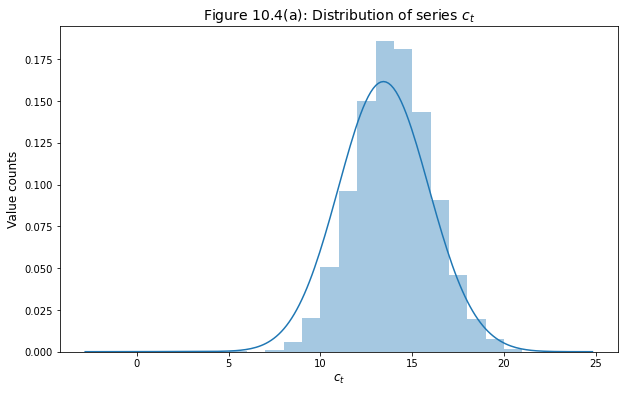

In [13]:
# 10.4(a) Compute the series c_t = c_{t,l} (all bets are long)
df_events_10_4 = df_budget.copy()
df_events_10_4['c_t'] = df_events_10_4['active_long'] - df_events_10_4['active_short']
fig_10_4, ax_10_4 = plt.subplots(figsize=(10,6))
ax_10_4a = sns.distplot(df_events_10_4['c_t'], bins=20, kde=True, kde_kws={"bw":0.6}, norm_hist=False, ax=ax_10_4)
ax_10_4a.set_xlabel('$c_t$', fontsize=12)
ax_10_4.set_ylabel("Value counts", fontsize=12)
ax_10_4a.set_title("Figure 10.4(a): Distribution of series $c_t$", fontsize=14)
plt.show()

**Figure 10.4(a)** shows the distribution of the number of concurrent long bets at any given time $t$. Note the slightly longer tail to the left due to the maximum number of bets being limiting in the start of the sequence.

The `bet_size_reserve` function employs the EF3M algorithm on the series $\{c_t\}$ after calculating it, essentially following the steps described in exercise 10.4. The `return_parameters` option let's the user see the parameters of the mixture of two Gaussian distributions.

In [14]:
# 10.4(b) Fit a mixture of 2 Gaussians
# 10.4(c) Calculating the bet size using the mixture of 2 Gaussians

# This is accomplished using a single mlfinlab function

df_reserve, params = bet_size_reserve(df_events_10_4['t1'],
                                      df_events_10_4['side'],
                                      fit_runs=100,
                                      epsilon=1e-05,
                                      factor=5,
                                      variant=2,
                                      max_iter=100_000,
                                      num_workers=8,
                                      return_parameters=True)

print(params)
display(df_reserve.head(10))

|#########################| Completed 100 of 100 fitting rounds.

{'mu_1': 13.39661, 'mu_2': 13.47765, 'sigma_1': 2.51566, 'sigma_2': 2.01881, 'p_1': 0.15217}


,t1,side,active_long,active_short,c_t,bet_size
2000-01-01,2000-01-18 09:52:55.127172,1,1,0,1,5.587166e-08
2000-01-02,2000-01-14 05:50:47.037544,1,2,0,2,4.460664e-07
2000-01-03,2000-01-05 11:27:59.715645,1,3,0,3,2.808641e-06
2000-01-04,2000-01-15 21:25:39.471161,1,4,0,4,1.539266e-05
2000-01-05,2000-01-20 02:28:38.652251,1,5,0,5,7.560507e-05
2000-01-06,2000-01-25 05:23:41.738727,1,5,0,5,7.560507e-05
2000-01-07,2000-01-11 07:20:15.605093,1,6,0,6,3.395000e-04
2000-01-08,2000-01-25 21:06:25.611093,1,7,0,7,1.402222e-03
2000-01-09,2000-01-26 03:18:31.241395,1,8,0,8,5.253800e-03
2000-01-10,2000-01-25 23:31:15.504108,1,9,0,9,1.738410e-02


Here we add the results from `bet_size_reserve` to the `bet_sizes` DataFrame, and compare the distribution of bet sizes across the three different strategies.

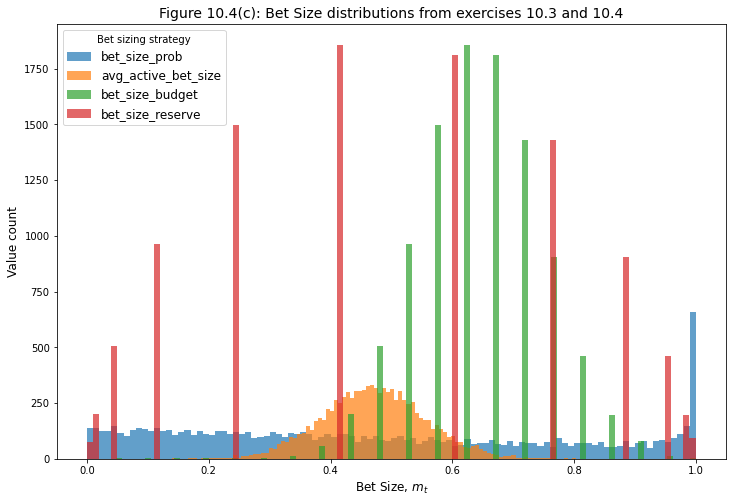

In [15]:
betsizes_10_4 = betsizes_10_3.copy()
betsizes_10_4['bet_size_reserve'] = df_reserve['bet_size']

# Plotting
fig_10_4c, ax_10_4c = plt.subplots(figsize=(12,8))
for c in betsizes_10_4.columns:
    ax_10_4c.hist(betsizes_10_4[c].to_numpy(), bins=100, label=c, alpha=0.7)
ax_10_4c.legend(loc='upper left', fontsize=12, title="Bet sizing strategy", title_fontsize=10)
ax_10_4c.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax_10_4c.set_ylabel("Value count", fontsize=12)
ax_10_4c.set_title("Figure 10.4(c): Bet Size distributions from exercises 10.3 and 10.4", fontsize=14)
ax_10_4.set_ylim((0, 2500))
plt.show()

**Figure 10.4(c)** shows the distribution of bet sizes as calculated in exercises 10.3 and 10.4. `bet_size_budget` is the number of active bets divided by the maximum number of active bets, while `bet_size_reserve` is the bet sizes calculated using the fit mixture of 2 Gaussian distributions. Note that both are 20 discrete values due to the underlying data as previously discussed.

**10.4(d) Discussion**

The bet size distribution calculated in exercise 3, `bet_size_budget`, and exercise 4, `bet_size_reserve`, are both made up of discrete values. Since the series $\{c_t\}$ is made up of integers between 1 and 20, the bet size from exercise 3, $m_t=c_{t,l}\frac{1}{\tilde{c_l}}$, is also a set of discrete values bounded by $[\frac{1}{\tilde{c_l}}, 1]$ (since there is always at least 1 active bet for any given $t$). However, $98\%$ of all bet sizes fall between $[0.45, 0.9]$, with a mean at $0.67$.

In exercise 4 the bet size is calculated using $c_t$ as an input, which results in the bet sizes being a series composed of 20 unique values. Here the bet size values are bounded by $(0, 1)$ but are spread out more evenly across the range than in exercise 3; here $98\%$ of the bet sizes fall between $[0.01, 0.998]$, with a lower mean of $0.50$.

Even though we are examining a *long-only* betting strategy, the bet sizes calculated in exercise 4 typically get much closer to zero (i.e. not placing the bet at all), whereas in exercise 3 $99\%$ of all bet sizes are at least $0.45$.

In [16]:
print("Quantiles of the bet size values as calculated in the previous exercises:")
display(pd.concat([betsizes_10_4.quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999]),
                   betsizes_10_4.mean().to_frame(name='Mean').transpose()]))

Quantiles of the bet size values as calculated in the previous exercises:


,bet_size_prob,avg_active_bet_size,bet_size_budget,bet_size_reserve
0.001,0.000580,0.206186,0.333333,0.001402
0.01,0.006542,0.277212,0.428571,0.017384
0.05,0.037781,0.333166,0.476190,0.049478
0.25,0.199764,0.415112,0.571429,0.240820
0.5,0.429563,0.470186,0.619048,0.411183
0.75,0.740689,0.526123,0.714286,0.769039
0.95,0.997446,0.612158,0.809524,0.954084
0.99,1.000000,0.668495,0.857143,0.984249
0.999,1.000000,0.736150,0.952381,0.998817
Mean,0.473318,0.471183,0.641052,0.498667


----
#### EXERCISE 10.5
Repeat exercise 1, where you discretize $m$ with a `stepSize=.01`, `setpSize=.05`, and `stepSize=.1`.

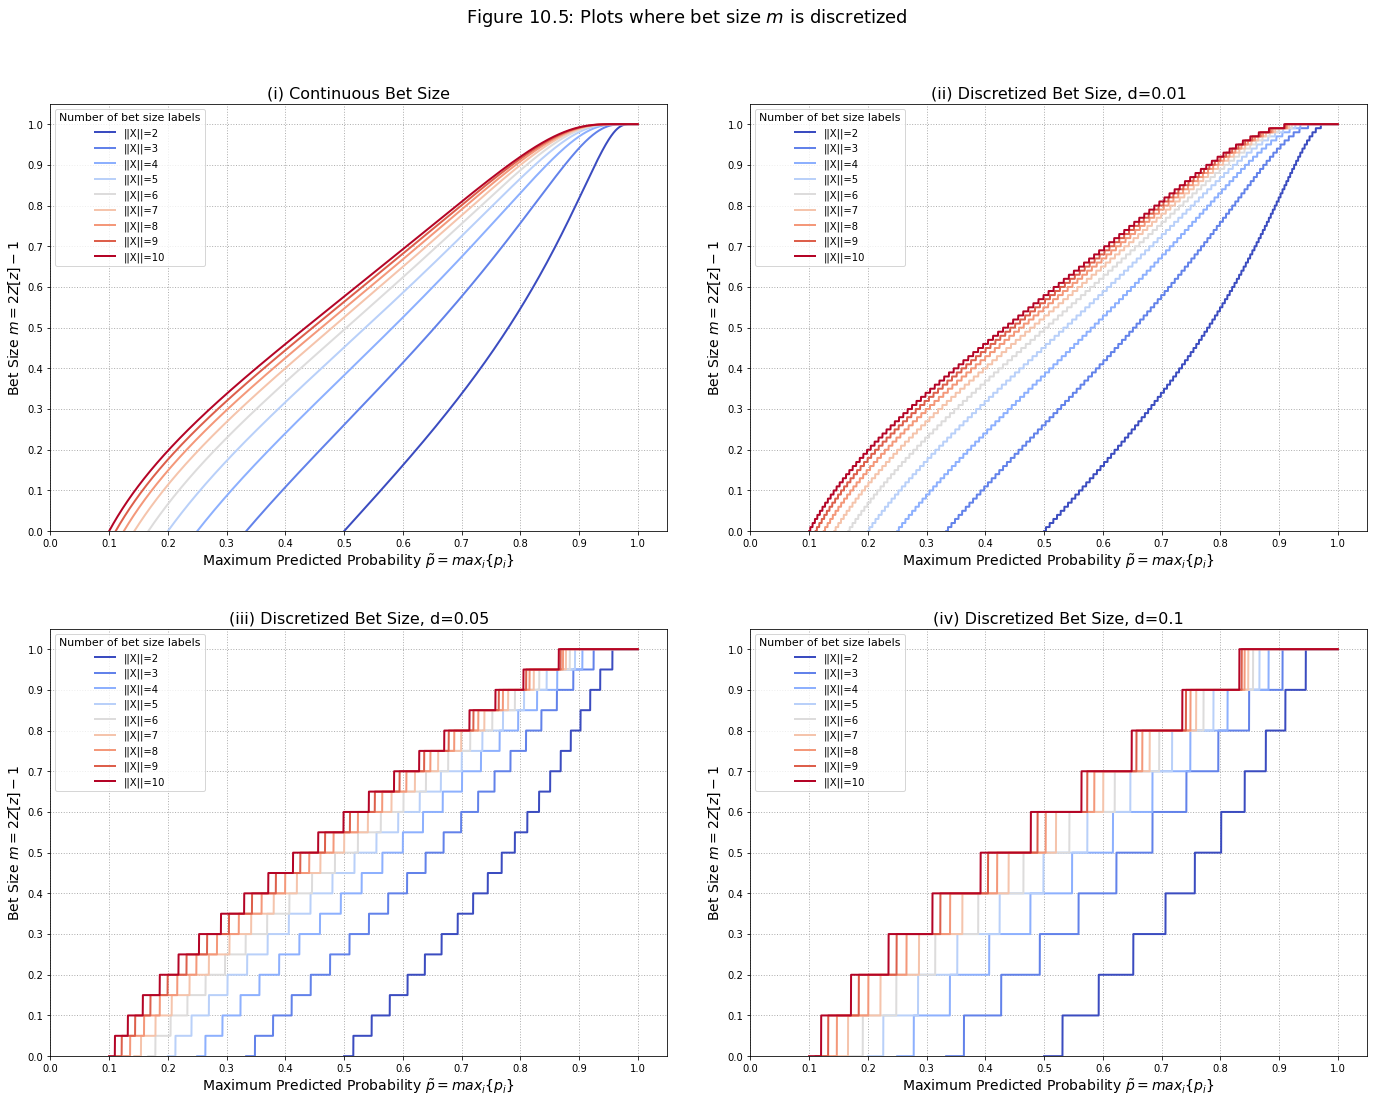

In [17]:
num_classes_list = [i for i in range(2, 11, 1)]  # Array of number of classes, 2 to 10
n = 10_000  # Number of points to plot


fig_10_5, ax_10_5 = plt.subplots(2, 2, figsize=(20, 16))
ax_10_5 = fig_10_5.get_axes()
d_list = [0.0, 0.01, 0.05, 0.1]
sub_fig_num = ['i', 'ii', 'iii', 'iv']
events_10_5 = events_2_classes.copy()  # Reuse dataframe structure from previous

for i, axi in enumerate(ax_10_5):
    colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))
    for num_classes in num_classes_list:
        min_prob, max_prob = 1 / num_classes, 1  # Possible range for maximum predicted probability, [1/||X||, 1]
        P = np.linspace(min_prob, max_prob, n, endpoint=False)  # Range of maximum predicted probabilities to plot
        events_10_5['prob'] = P
        events_10_5['bet_size_prob'] = bet_size_probability(events=events_10_5, prob=events_10_5['prob'], step_size=d_list[i], num_classes=num_classes)
        axi.plot(events_10_5['prob'], events_10_5['bet_size_prob'], label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

    axi.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=14)
    axi.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=14)
    axi.set_xticks([0.1*i for i in range(11)])
    axi.set_yticks([0.1*i for i in range(11)])
    axi.legend(loc="upper left", fontsize=10, title="Number of bet size labels", title_fontsize=11)
    axi.set_ylim((0,1.05))
    axi.set_xlim((0, 1.05))
    d = d_list[i]
    if not d==0.0:
        axi.set_title(f"({sub_fig_num[i]}) Discretized Bet Size, d={d}", fontsize=16)
    else:
        axi.set_title(f"({sub_fig_num[i]}) Continuous Bet Size", fontsize=16)
    axi.grid(linewidth=1, linestyle=':')

fig_10_5.suptitle("Figure 10.5: Plots where bet size $m$ is discretized", fontsize=18)
fig_10_5.tight_layout(pad=4)
plt.show()

----
#### EXERCISE 10.6
Rewrite the equations in Section 10.6, so that the bet size is determined by a power function rather than a sigmoid function.

We can substitute a power function to calculate bet size, $\tilde{m}$:

$$\tilde{m}[\omega, x] = sgn[x]|x|^\omega$$

$L[f_i, \omega, \tilde{m}]$, the inverse function of $\tilde{m}[\omega, x]$ with respect to the market price $p_t$, can be rewritten as:

$$L[f_i, \omega, \tilde{m}] = f_i - sgn[\tilde{m}]|\tilde{m}|^{1/\omega}$$

The inverse of $\tilde{m}[\omega, x]$ with respect to $\omega$ can be rewritten as:

$$\omega = \frac{log[\frac{\tilde{m}}{sgn(x)}]}{log[|x|]}$$

Where $x = f_i - p_t$ is still the divergence between the current market price, $p_t$, and the price forecast, $f_i$.

----
#### EXERCISE 10.7
Modify Snippet 10.4 so that in implements the equations you derived in exercise 6.

The code for the modified functions can be found in the [`mlfinlab.bet_sizing.ch10_snippets.py`](https://github.com/hudson-and-thames/mlfinlab/blob/master/mlfinlab/bet_sizing/ch10_snippets.py) file in the `mlfinlab` library. The exercise below creates a figure by employing the `bet_size_power` function from this submodule.

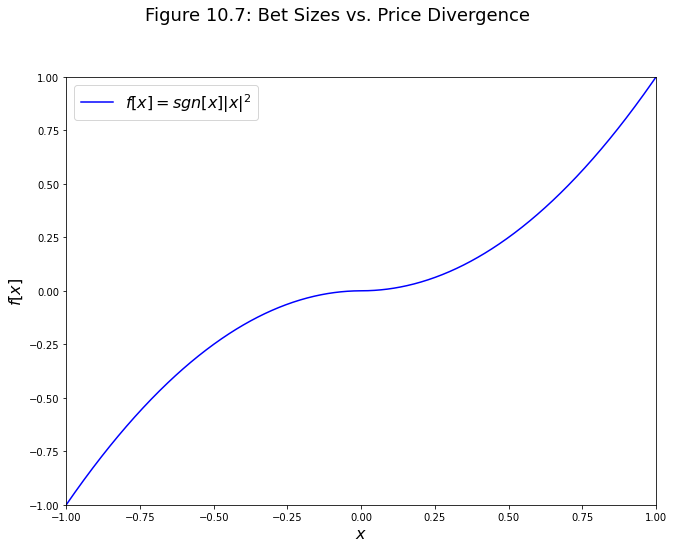

In [18]:
# Setup data for replicating Figure 10.3
mP, f, wParams = 100, 115, {'divergence': 10, 'm': 0.95}
n_points = 1000
X = np.linspace(-1.0, 1.0, n_points)

w = 2
bet_sizes_power = np.array([bet_size_power(w, xi) for xi in X])

# Plotting
fig_10_7, ax_10_7 = plt.subplots(figsize=(10,8))
ax_10_7.plot(X, bet_sizes_power, label='$f[x]=sgn[x]|x|^2$', color='blue', linestyle='-')
ax_10_7.set_xlabel("$x$", fontsize=16)
ax_10_7.set_ylabel("$f[x]$", fontsize=16)
ax_10_7.set_xlim((-1, 1))
ax_10_7.set_ylim((-1, 1))
fig_10_7.suptitle("Figure 10.7: Bet Sizes vs. Price Divergence", fontsize=18)
plt.legend(loc='upper left', fontsize=16)
fig_10_7.tight_layout(pad=3)
plt.show()

**Figure 10.7** shows a plot of bet size vs. price divergence using the same parameters as Figure 10.3 on page 148 of "Advances in Financial Machine Learning".